In [1]:
#Time series data of HD50896 from TESS - 1st part
import os, sys

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import numpy as np

import astropy
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
# from astropy.utils.data import get_pkg_data_filename   #time-series extraction tool
# from astropy.timeseries import TimeSeries

import lightkurve as lk    #good time-series library

import pandas as pd 

from scipy.optimize import curve_fit

In [2]:
#read from manually downloaded data from MAST
hd_lc2 = lk.read('tess2019006130736-s0007-0000000078959225-0131-s_lc.fits')
hd_lc2

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1491.635714689585,3.8737297e+05,6.8870880e+01,3.9365473e-03,190207,776.67070,1216.68494,3.7572344e+05,6.6570587e+01,8.1707026e+03,1.2137275e+01,3.8737297e+05,6.8870880e+01,1000000000,nan,nan,nan,nan,776.67070,1.7015493e-04,1216.68494,1.6884287e-04,2.3079609e-02,-6.5482873e-03
1491.6371035858122,3.8711306e+05,6.8826881e+01,3.9365552e-03,190208,776.67008,1216.69585,3.7539088e+05,6.6528053e+01,8.0823950e+03,1.2092155e+01,3.8711306e+05,6.8826881e+01,0,nan,nan,nan,nan,776.67008,1.7024914e-04,1216.69585,1.6884148e-04,2.2055011e-02,5.3321645e-03
1491.6384924820384,3.8704984e+05,6.8834229e+01,3.9365632e-03,190209,776.67202,1216.68852,3.7547794e+05,6.6535156e+01,8.0731196e+03,1.2093919e+01,3.8704984e+05,6.8834229e+01,0,nan,nan,nan,nan,776.67202,1.7016851e-04,1216.68852,1.6874688e-04,2.3819130e-02,-2.0609125e-03
1491.6398813782641,3.8703122e+05,6.8822868e+01,3.9365711e-03,190210,776.66984,1216.69641,3.7546622e+05,6.6524178e+01,8.0396680e+03,1.2064366e+01,3.8703122e+05,6.8822868e+01,0,nan,nan,nan,nan,776.66984,1.7014121e-04,1216.69641,1.6863240e-04,2.1678708e-02,6.1852471e-03
1491.6412702744913,3.8692656e+05,6.8808937e+01,3.9365790e-03,190211,776.67205,1216.69356,3.7536966e+05,6.6510712e+01,7.9750469e+03,1.2050604e+01,3.8692656e+05,6.8808937e+01,0,nan,nan,nan,nan,776.67205,1.7014364e-04,1216.69356,1.6864123e-04,2.3713114e-02,2.8350649e-03
1491.6426591707182,3.8707259e+05,6.8800247e+01,3.9365869e-03,190212,776.67280,1216.69230,3.7529422e+05,6.6502312e+01,7.9798506e+03,1.2048139e+01,3.8707259e+05,6.8800247e+01,0,nan,nan,nan,nan,776.67280,1.7019435e-04,1216.69230,1.6892016e-04,2.5192684e-02,1.6063373e-03
1491.6440480669437,3.8702019e+05,6.8797707e+01,3.9365948e-03,190213,776.67335,1216.69432,3.7543819e+05,6.6499855e+01,7.9038247e+03,1.1994993e+01,3.8702019e+05,6.8797707e+01,0,nan,nan,nan,nan,776.67335,1.7004661e-04,1216.69432,1.6859770e-04,2.5518924e-02,4.2226263e-03
1491.6454369631701,3.8686788e+05,6.8765099e+01,3.9366027e-03,190214,776.67170,1216.69484,3.7512391e+05,6.6468338e+01,7.8674053e+03,1.1977653e+01,3.8686788e+05,6.8765099e+01,0,nan,nan,nan,nan,776.67170,1.7014380e-04,1216.69484,1.6887613e-04,2.3471924e-02,4.5842063e-03


In [3]:
hd_lc2.filename

'tess2019006130736-s0007-0000000078959225-0131-s_lc.fits'

Trying to obtain the PDCSAP flux from the time series. However, a little bit of context first.

- **SAP light curve** is summing together the brightness of pixels that fall within an aperture set by any of these survey missions - referred to as the **optimal aperture**, though, still subject to systematic artifacts of the respective mission.

- **PDCSAP light curve** has more treatment than SAP. The PDCSAP pipeline attempts to remove systematic artifacts while keeping planetary transits intact (made with planet detection intentions)

Text(0.5, 1.0, 'PDCSAP Light Curve of HD 050896 - ts2')

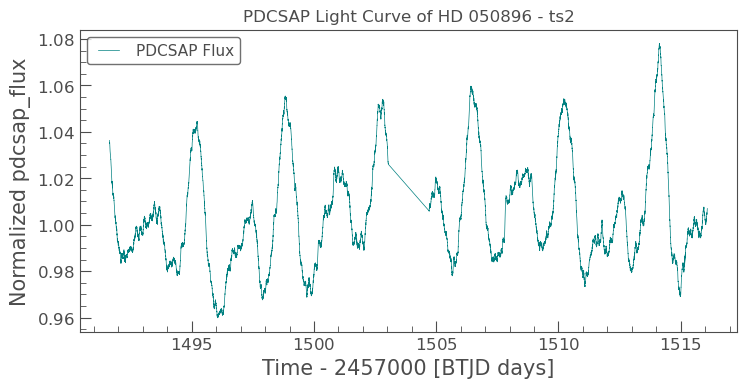

In [4]:
ax = hd_lc2.plot(column='pdcsap_flux', label='PDCSAP Flux', color='teal', normalize=True)    #PDCSAP flux
ax.set_title('PDCSAP Light Curve of HD 050896 - ts2')
#hd_lc2.plot(column='sap_flux', label='SAP Flux', color='r', normalize=True, ax=ax);    #SAP flux
#ax.set_xlim(1470, 1471)
#ax.set_ylim(1.005, 1.01)

In [5]:
#timeseries's metadata
hd_lc2.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 78959225',
 'TICID': 78959225,
 'RADESYS': 'ICRS',
 'RA_OBJ': 103.554350353116,
 'DEC_OBJ': -23.9283389773658,
 'EQUINOX': 2000.0,
 'EXPOSURE': 19.368532207101,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 24.455217433208,
 'LIVETIME': 19.368532207100888,
 'TSTART': 1491.63502035698,
 'TSTOP': 1516.090237558706,
 'DATE-OBS': '2019-01-08T03:13:16.575',
 'DATE-END': '2019-02-01T14:08:47.341',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.309999942779541,
 'GAINB': 5.239999771118164,
 'GAINC': 5.230000019073486,
 'GAIND': 5.239999771118164,
 'READNOIA': 10.142099380493164,
 

### Lomb-Scargle Periodogram of HD 050896

In [6]:
#Lomb-Scargle Periodogram - normalised to parts per million
pg_hd_lc2 = hd_lc2.normalize(unit='ppm').to_periodogram()
pg_hd_lc2

LombScarglePeriodogram(ID: TIC 78959225)

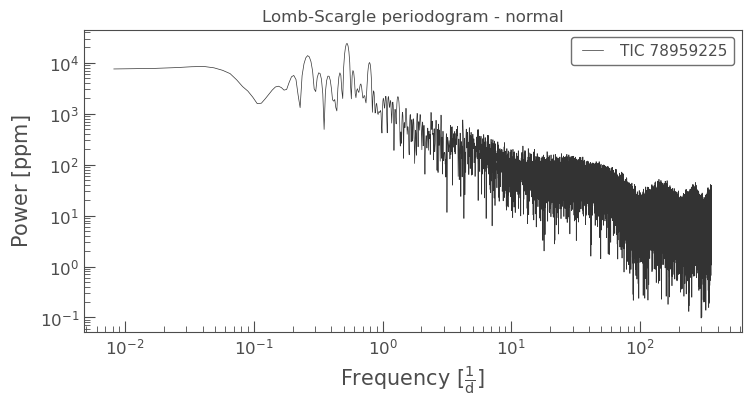

In [7]:
#Inspecting the periodogram
ax = pg_hd_lc2.plot(view='frequency', scale='log')
#ax.set_xlim(0,15)
ax.set_title('Lomb-Scargle periodogram - normal')
plt.savefig('LS_lc2_log')

In [8]:
pg_hd_lc2.period_at_max_power   #period at max power

<Quantity 1.88106374 d>

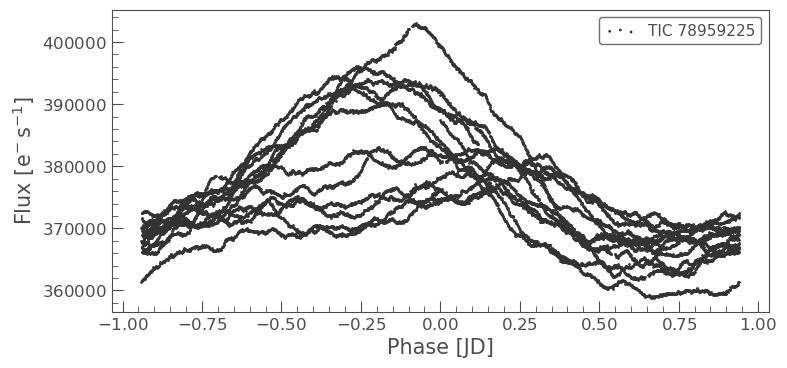

In [9]:
#Folding light curve using max power period
hd_lc2.fold(period=pg_hd_lc2.period_at_max_power).scatter()

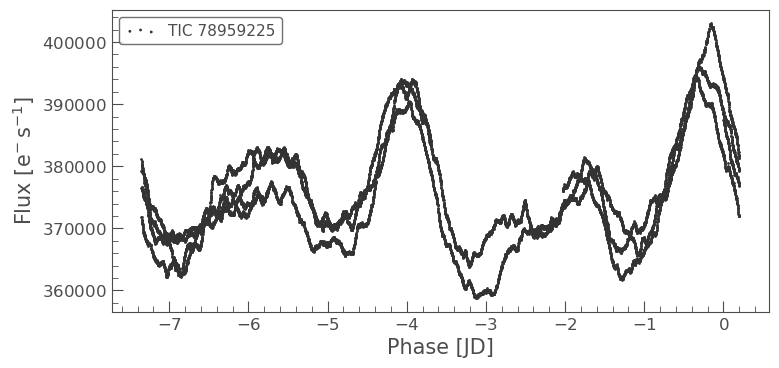

In [10]:
#Testing with folding params & then remaking periodogram
hd_lc2.fold(period=4.015*pg_hd_lc2.period_at_max_power, wrap_phase=0.2).scatter()

Hmm... Is this the best this star can do in terms of time series??? Ask Ian. 

1.8933887321668015 d


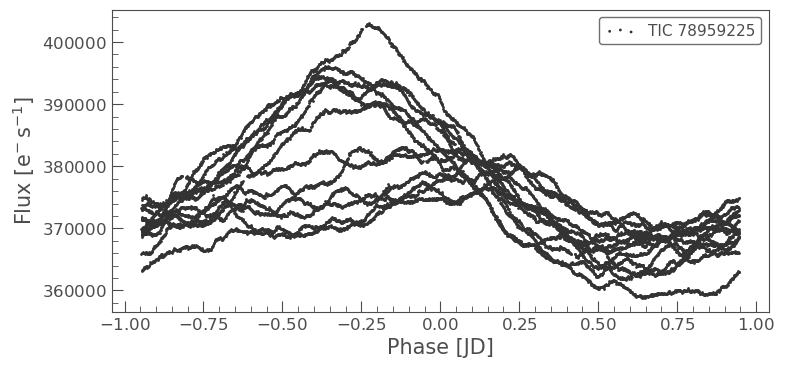

In [11]:
#Increasing oversampling frequency = 10
pg_hd_lc2 = hd_lc2.normalize(unit='ppm').to_periodogram(minimum_period=1.5*u.day, maximum_period=2.2*u.day, oversample_factor=10)
print(pg_hd_lc2.period_at_max_power)
hd_lc2.fold(period=pg_hd_lc2.period_at_max_power).scatter()

Text(0.5, 1.0, 'Edited LS periodogram - oversample_f = 10; min_p = 1.5 days, max_p = 2.2 days')

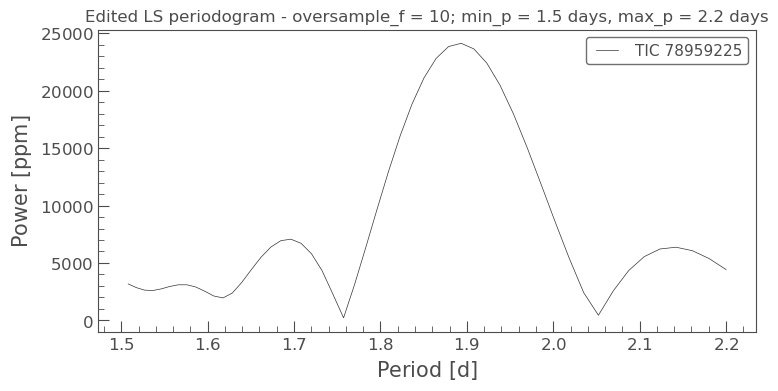

In [12]:
#Inspecting LS post-modification
ax = pg_hd_lc2.plot(view='period', scale='linear')
#ax.set_xlim(0,20)
ax.set_title('Edited LS periodogram - oversample_f = 10; min_p = 1.5 days, max_p = 2.2 days')

In [13]:
#Writing relevant light curves into ascii files
hd_lc2.write("hd050896_lc2.txt", format="ascii.fixed_width", overwrite=True)